# Introduction

> This work was based on the code made by Chris McCormick and Nick Ryan, available at https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX

> This work was originally written in portuguese, so some of the tables and results may contain words in portuguese

In this work, I am going to describe the database used to fine tune a BERT model, as well as the pre-processing steps applied to the data. Next, I am going to detail the training, validation and testing steps of the tuned model. To develop this analysis, the `Python` programming language (version 3.11.3) was used in conjunction with the source code editor Visual Studio Code. Furthermore, `Python` packages were used, such as `numpy` (Harris et al., 2020) (version 1.24.4), `pandas` (Wes McKinney, 2010) (version 2.0.3), `transformers` (Wolf et al., 2019) (version 4.30.2) and `torch` (Paszke et al., 2019) (version 2.0.1).

# Setup

In [ ]:
# Importing packages and functions
import os
import time
import datetime
import random
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statistics import mean
from collections import Counter
from langdetect import detect, DetectorFactory
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler, Subset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

In [2]:
# Declaring constants
DF_ORIGINAL = r"dados/WELFake_Dataset.csv"
DF_FINAL = r"dados/data.csv"
MODEL_FOLDER = r"dados/model_v1/"

device = torch.device("cpu")
os.environ['CURL_CA_BUNDLE'] = ''  # If this error message shows up "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed" run these commands to reduce the version of the requests package: "pip uninstall requests" and "pip install requests==2.27.1"

In [3]:
# Declaring the seed random so that this code is reproducible
my_seed = 288933

random.seed(my_seed)
np.random.seed(my_seed)
torch.manual_seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

# Pre-Processing

The original dataset (Verma et al., 2021) was obtained from the Kaggle portal and contains information about 72,134 news articles in the English language, of which 35,028 are true news and 37,106 are fake. To compose the dataset, Verma et al. (2021) extracted articles from the Kaggle, McIntire, Reuters and BuzzFeed Political portals. The dataset has 3 columns: "title", which presents the title of the news in text format; "text", which presents the news content in text format; and "label", which is 0 for true news and 1 for fake news. The objective of this work is to use the "title" and "label" columns of the presented database to adjust a BERT model for supervised binary text classification, capable of detecting when the title of a news story in English comes from a fake article or not.

In [4]:
# Importing the dataset
df = pd.read_csv(DF_ORIGINAL, index_col=0)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
df.groupby('label').size()

label
0    35028
1    37106
dtype: int64

In [6]:
# Selecting only the title and classification columns
df = df[['title', 'label']]

n_row_before = len(df)
df = df[~df['title'].isnull()]
df = df[~df['label'].isnull()]

n_row_after = len(df)
print(f'Number of observations removed for null values in title or rating columns: {n_row_before- n_row_after}')

Number of observations removed for null values in title or rating columns: 558


In [7]:
# Removing duplicated rows
n_row_before = len(df)
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset='title', keep=False, inplace=True, ignore_index=True)  # Values removed here are titles that have both labels

n_row_after = len(df)
print(f'Number of observations removed for duplicate values: {n_row_before- n_row_after}')

Number of observations removed for duplicate values: 9233


Some titles are in languages other than English. To remove them, we will use the `langdetect` package (version 1.0.9).

In [8]:
# Classifying the titles by language
DetectorFactory.seed = 0

language = []
for title in df['title']:
    try:
        language.append(detect(title))
    except:
        language.append('error')
        pass

print(Counter(language))

Counter({'en': 60048, 'de': 814, 'fr': 212, 'es': 204, 'ru': 153, 'ca': 152, 'it': 116, 'nl': 96, 'af': 73, 'da': 72, 'no': 68, 'id': 64, 'ro': 50, 'pt': 41, 'et': 27, 'sv': 24, 'tl': 21, 'ar': 19, 'vi': 15, 'lt': 11, 'so': 10, 'tr': 10, 'error': 7, 'hr': 7, 'cy': 6, 'fi': 4, 'pl': 3, 'sl': 3, 'sw': 3, 'bg': 3, 'el': 2, 'lv': 1, 'fa': 1, 'sq': 1, 'zh-cn': 1, 'hu': 1})


We are going to remove rows where the `langdetect` package classified titles as Russian, Arabic, Lithuanian, Turkish, Polish, Bulgarian, Greek, Chinese, or titles that could not be classified by the package. Several titles in English were classified as being from other languages and, therefore, it is considered that this classification was not very accurate. Furthermore, it is important to keep in mind that several titles in languages other than English could not be removed from the database automatically, which could cause noise in the adjusted model.

In [9]:
# Removing titles in other languages
n_row_before = len(df)
df.drop([idx for idx, l in enumerate(language) if l in ['ru', 'ar', 'lt', 'tr', 'pl', 'bg', 'el', 'zh-cn', 'error']]
        ,axis=0  # rows
        ,inplace=True)
df.reset_index(drop=True, inplace=True)

n_row_after = len(df)
print(f'Number of titles removed for not being in English: {n_row_before- n_row_after}')

Number of titles removed for not being in English: 209


To analyze the size of each title, let's consider the number of tokens in the title tokenized by the BERT Base pre-trained model. The information on the maximum number of tokens will be useful in the fine tunning step.

In [10]:
# Declaring the BERT Base Uncased model tokenizer (which considers all letters as lowercase). This object will be declared again later, but we need it here to get descriptive statistics on the number of tokens per title.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# For every title, calculate the size of the tokens vector 
df['n_token'] = [len(tokenizer.encode(title, add_special_tokens=True)) for title in df['title']]

# Analisando algumas estatísticas
# Analyzing some statistics
print('Minimum tokens: ', min(df['n_token']))
print('Maximum tokens: ', max(df['n_token']))
print('Average of tokens: ', round(mean(df['n_token']), 4))
print('Number of tokens per percentile: ', np.quantile(df['n_token'], q=[.1, .2, .3, .4, .5, .6, .7, .8, .9]))
print('Number of titles with more than 128 tokens: ', sum([i > 128 for i in df['n_token']]))
print('Number of titles with more than 64 tokens: ', sum([i > 64 for i in df['n_token']]))
print('Number of titles with more than 32 tokens: ', sum([i > 32 for i in df['n_token']]))

Minimum tokens:  3
Maximum tokens:  96
Average of tokens:  18.1779
Number of tokens per percentile:  [12. 13. 15. 16. 17. 19. 20. 22. 25.]
Number of titles with more than 128 tokens:  0
Number of titles with more than 64 tokens:  3
Number of titles with more than 32 tokens:  1415


In [11]:
# Pre-processed dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62134 entries, 0 to 62133
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    62134 non-null  object
 1   label    62134 non-null  int64 
 2   n_token  62134 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


,title,label,n_token
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,35
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,30
2,"Bobby Jindal, raised Hindu, uses story of Chri...",0,22
3,SATAN 2: Russia unvelis an image of its terrif...,1,25
4,About Time! Christian Group Sues Amazon and SP...,1,18


In [12]:
df.groupby('label').size()

label
0    34404
1    27730
dtype: int64

During pre-processing, no punctuation marks or stop words were removed, which is a set of words that are normally disregarded from analysis, such as prepositions or conjunctions. This choice was made because removing such tokens would imply removing context that the model could have used to obtain better results. Furthermore, researchers such as Schofield et al. (2017) have debated whether removing stop words actually positively impacts the performance of NLP models.

After the pre-processing step, the final database has 62,134 observations, of which 34,404 are true news and 27,730 are fake. It is possible to notice that the data is slightly unbalanced, as approximately 55.37% of the news is true and 44.63% is false.

As an example of a true news headline, we have: "Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid".

As an example of a fake news headline, we have: "UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE PEACEFUL PROTESTERS... In Her Home State Of North Carolina [VIDEO]".

With the pre-processed database ready, let's export it to a CSV file.

In [14]:
df.to_csv(DF_FINAL, index=False)

In [12]:
# To save time, in case the DF_FINAL file has already been saved previously
df = pd.read_csv(DF_FINAL)

# Tuning the pre-trained model

Using the concept of transfer learning to increase training speed, the model parameters were initialized from the pre-trained `BERT Base Uncased` model, which does not distinguish between uppercase and lowercase characters. The `transformers` package provides a class called `BertForSequenceClassification`, which loads the parameters of the pre-trained model and provides tools that assist in the fine-tuning stage in sequence classification tasks. As we are interested in making a binary classification, we use a classifier with only two categories.

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

The first step we have to take to adjust the model is to tokenize the bank's sentences. To do this, we will use the `encode_plus` method so that each sentence is tokenized by the WordPiece method. Among the settings, we will truncate sentences that have more than 64 tokens for optimization. As seen previously, only 3 sentences in the database have more than 64 tokens, so it is expected that truncation will not affect the adjustment results.

In [14]:
# Tokenizes all sentences using the wordpiece method
input_ids = []
attention_masks = []

for sentence in df['title'].values:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True,  # Insert the tokens '[CLS]' and '[SEP]' at the beginning and end of the list, respectively
                        max_length = 64,  # Sentences longer than 64 tokens will be truncated and shorter sentences will have the rest of the list filled with the '[PAD]' token
                        truncation=True,  # To use truncation
                        padding='max_length',  # To include the token '[PAD]' if necessary
                        return_attention_mask = True,  # Returns the attention list, which is 1 in the position where the token is not '[PAD]' and is 0 when the token is '[PAD]'
                        return_tensors = 'pt'  # Returns the lists as a tensor type object
                   )

    # Saves the tokenized sentence and attention list into a list
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Transform the list of tensors into a tensor with multiple lists
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['label'].values)

# Exemplifying the result with the first sentence of the dataset
print('Original sentence: ', df['title'].values[0])
print('Tokenized sentence: ', input_ids[0])
print('Attention: ', attention_masks[0])
print('Label: ', labels[0])

Original sentence:  LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]
Tokenized sentence:  tensor([  101,  2375,  7285,  2006,  2152,  9499,  2206,  8767,  2114, 10558,
         1998, 12461,  2006,  1023,  1011,  2340,  3762,  1001,  2304,  3669,
         6961, 18900,  3334,  1998,  1001,  1042,  2100,  2546,  2683, 14526,
        15554,  1031,  2678,  1033,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Attention:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Label:  tensor(1)


With the tokenized sentences, we will divide the database between training, validation and testing, using the separation ratio 80%/10%/10% for each partition, respectively.

In [15]:
# Combining the lists obtained in the tokenization step to create a TensorDataset object
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculating the number of sentences each set needs to have to follow the 80-10-10 ratio
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Dividing the sets randomly according to the calculated sample size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} sentences for training'.format(train_size))
print('{:>5,} sentences for validation'.format(val_size))
print('{:>5,} sentences for test'.format(test_size))

49,707 sentences for training
6,213 sentences for validation
6,214 sentences for test


Then, in the validation phase, we sought to choose the best set of hyperparameters, based on the model's performance in the validation set. For tasks of fine-tuning a pre-trained BERT model, Devlin et al. (2018) recommend using a mini-batch size of 16 or 32, a learning rate of 2e-05, 3e-05 or 5e-05 and a number of epochs of 2, 3 or 4.

Since training a neural network with the entire dataset at once can be computationally expensive and memory-intensive, it is possible to divide the dataset into mini-batches and update the model parameters based on the gradients calculated in each mini-batch. The larger the mini-batch size, the more accurate the gradient estimate and the more computational power required.

The learning rate determines the step size at which the model parameters are updated during each iteration of the training process. The higher the learning rate, the faster the parameters converge and the greater the risk of the optimal value being exceeded.

An epoch is a complete pass through the entire training dataset during the training process. In each epoch, the model processes all mini-batches in the training dataset, calculates gradients, updates parameters and evaluates the model's performance. Too few epochs can lead to underfitting, while too many epochs can lead to overfitting.

18 models were adjusted with the first 2000 observations from the dataset and, for each adjustment, a different combination of the hyperparameter values recommended by Devlin et al. (2018) was used. The results were observed and, based on the analysis of metrics such as accuracy, loss and adjustment time of the models in the validation set, I have chosen the mini-batch size of 32, the learning rate of 3e-05 and 3 epochs.

In [16]:
# Hyperparameter
batch_size = 32
learning_rate = 3e-5
epochs = 3

In [17]:
# Separating the sets considering the batch size:
# For training, we select batches randomly. For validation and testing, we select batches sequentially.
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)
prediction_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

In [18]:
# The optimizer is the object responsible for updating the model parameters
# We will be using the AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [19]:
# Creates the object responsible for reducing the learning rate as the model learns
# The 'num_training_steps' is calculated as the number of batches multiplied by the number of epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(train_dataloader) * epochs)

It is also important to declare some auxiliary functions. Among them, we will declare `flat_accuracy`, which returns the proportion of prediction hits and `format_time`, which returns the time in the format of hours, minutes and seconds given the total number of seconds.

In [20]:
# Function that calculates the accuracy of predicted values against the labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

Finally, let's start training the model using the auxiliary variables created so far. It is important to note that this is the most time-consuming and computationally demanding step of the entire process.

In [26]:
training_stats = []  # Let's store some model evaluation statistics in this object

initial_time = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================

    # Performs a complete pass over the training set

    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    t0 = time.time()  # Measures the training time of this epoch
    total_train_accuracy = 0  # Reset the full accuracy for this epoch
    total_train_loss = 0  # Reset the full loss for this epoch

    model.train()  # Puts the model in training mode
    # The method 'train()' only changes the state of the 'model' object, it does not actually train the model.
    # The 'dropout' and 'batchnorm' layers behave behave differently during training
    # versus testing (https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch).
    
    # For each batch of the training set...
    for step, batch in enumerate(train_dataloader):
        # Prints the progress to the user every 40 batches
        if step % 40 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.    Time elapsed: {:}.'.format(step, len(train_dataloader), format_time(time.time() - t0)))

        # 'batch' is an object that contains 3 tensors:
        #   [0]: input_ids
        #   [1]: attention_masks
        #   [2]: labels
        # Let's copy each tensor to the CPU using the '.to()' method
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()  # We need to clear any previously calculated gradients before performing the backward step
        # PyTorch does not do this automatically due to RNN training characteristics
        # (https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        
        result = model(b_input_ids,
                       token_type_ids=None,  # 'None' because we are not in the context of Next Sentence Prediction
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        # Performs the model training with data from this batch, using the forward function.
        # Although we use the 'model' function, the arguments from this function are going to another function called 'forward'.
        # Here is the documentation of the returned results:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput

        loss = result.loss  # Classification loss. How "far" the model prediction was in relation to the true label
        logits = result.logits  # Classification score
        # For each sentence, the label with the highest score will be the one that the model will choose as the true label of the sentence

        total_train_loss += loss.item()  # Accumulating the training error across all batches so we can calculate the average loss at the end
        
        # Moving the logits and labels to the CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)  # Accumulating the training accuracy

        loss.backward()  # Execute the backward method to calculate gradients

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # This avoids the explosive gradient problem

        optimizer.step()  # Update model parameters and perform a step using the computed gradient
        
        scheduler.step()  # Update the learning rate
    
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)  # Calculate the average training accuracy
    print("  Acuracia: {0:.2f}".format(avg_train_accuracy))

    avg_train_loss = total_train_loss / len(train_dataloader)  # Calculate the average loss over all of the batches

    training_time = format_time(time.time() - t0)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # Once the training epoch is complete, we will measure the model's performance on validation data    

    print("\nValidating...")

    t0 = time.time()

    model.eval()  # Puts the model in validation mode

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        # Similar to training, we will store the batch values
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 'torch.no_grad()' saves processing time by not computing some metrics that are only used in the training phase
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
            # Execute the 'forward' function with the validation data

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()  # Accumulating the validation error across all batches so that we can calculate the average loss at the end

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)  # Accumulating validation accuracy


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)  # Calculate the average validation accuracy
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)  # Calculate the average batch loss

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Storing statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training loss': avg_train_loss,
            'Validation loss': avg_val_loss,
            'Training accuracy': avg_train_accuracy,
            'Validation accuracy': avg_val_accuracy,
            'Training time': training_time,
            'Validation time': validation_time
        }
    )

print("\nTraining complete!")
print("Total training time: {:} (hh:mm:ss)".format(format_time(time.time()-initial_time)))


======== Epoca 1 / 3 ========
Treinando...
  Lote    40  de  1,554.    Tempo decorrido: 0:05:28.
  Lote    80  de  1,554.    Tempo decorrido: 0:11:26.
  Lote   120  de  1,554.    Tempo decorrido: 0:17:15.
  Lote   160  de  1,554.    Tempo decorrido: 0:23:26.
  Lote   200  de  1,554.    Tempo decorrido: 0:29:37.
  Lote   240  de  1,554.    Tempo decorrido: 0:35:47.
  Lote   280  de  1,554.    Tempo decorrido: 0:41:59.
  Lote   320  de  1,554.    Tempo decorrido: 0:48:08.
  Lote   360  de  1,554.    Tempo decorrido: 0:53:55.
  Lote   400  de  1,554.    Tempo decorrido: 1:00:06.
  Lote   440  de  1,554.    Tempo decorrido: 1:06:16.
  Lote   480  de  1,554.    Tempo decorrido: 1:12:27.
  Lote   520  de  1,554.    Tempo decorrido: 1:18:38.
  Lote   560  de  1,554.    Tempo decorrido: 1:24:48.
  Lote   600  de  1,554.    Tempo decorrido: 1:30:33.
  Lote   640  de  1,554.    Tempo decorrido: 1:36:52.
  Lote   680  de  1,554.    Tempo decorrido: 1:42:59.
  Lote   720  de  1,554.    Tempo deco

Let's export the model so we don't lose progress!

In [27]:
# Saving the trained model and tokenizer
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(MODEL_FOLDER)
tokenizer.save_pretrained(MODEL_FOLDER)

# Saving the model statistics
df_stats = pd.DataFrame(data=training_stats).set_index('epoch')
df_stats.to_csv(os.path.join(MODEL_FOLDER, 'training_stats.csv'))

# Saving the 'index' of all training sets. In this way, we can recreate the training, validation and test sets.
# This 'indexes' goes from 0 to len(dataset)-1, therefore they represent the order of each df's rows and not necessarily its indexes.
df_indexes = pd.DataFrame({'set': ['train' for _ in range(len(train_dataset))] + ['validation' for _ in range(len(val_dataset))] + ['test' for _ in range(len(test_dataset))]
                          ,'indice': train_dataset.indices + val_dataset.indices + test_dataset.indices})
df_indexes.to_csv(os.path.join(MODEL_FOLDER, 'indices_set.csv'), index=False)

In [22]:
# Analyzing training statistics
df_stats = pd.read_csv(os.path.join(MODEL_FOLDER, 'training_stats.csv'), index_col=0)
df_stats

,Perda de treinamento,Perda de validacao,Acuracia de treinamento,Acuracia de validacao,Tempo de treinamento,Tempo de validacao
epoca,,,,,,
1,0.194304,0.152900,0.921976,0.944872,3:55:57,0:10:01
2,0.094286,0.182497,0.967002,0.944551,3:45:13,0:09:05
3,0.042467,0.242404,0.987934,0.949679,3:44:42,0:09:19


It can be seen from the table above that the average loss between the mini-batches and the training accuracy decreased and increased, respectively, during the training phase. This seems to indicate that the model was able to learn from the data, obtaining a final accuracy of 98.79% on the training set. However, it is possible to observe that the average validation loss increased over the epochs, which may be an indication of overfitting. As the validation accuracy remained approximately constant throughout the epochs, the sign of overfitting observed in the average validation loss may not be as significant.

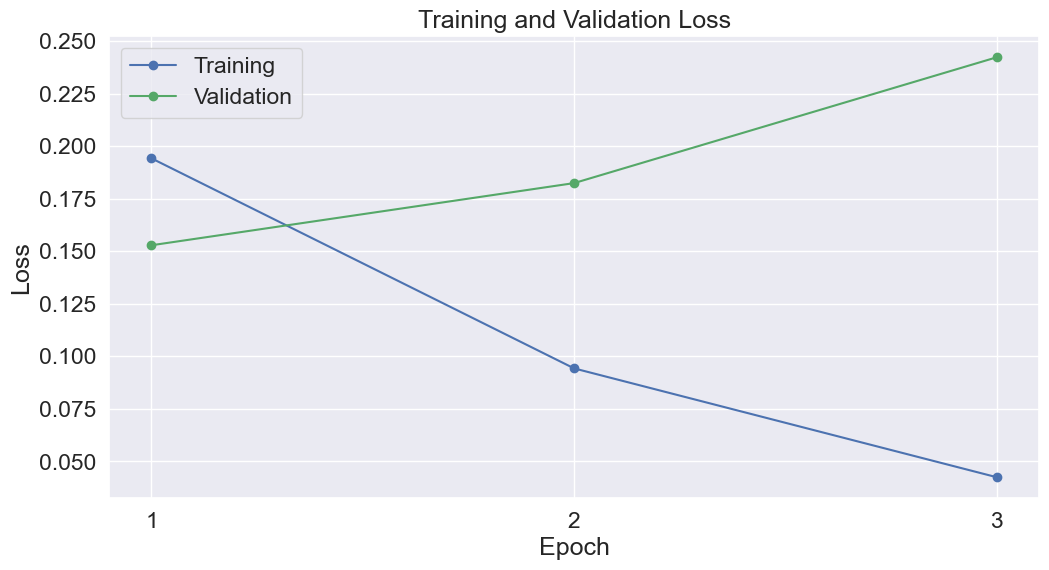

In [25]:
%matplotlib inline

# Using the style from the seaborn package
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve
plt.plot(df_stats['Perda de treinamento'], 'b-o', label="Training")
plt.plot(df_stats['Perda de validacao'], 'g-o', label="Validation")

# Label the plot
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

# Evaluating the model

After tuning, we will evaluate the model's performance on the test set

In [26]:
tokenizer = BertTokenizer.from_pretrained(MODEL_FOLDER)
model = BertForSequenceClassification.from_pretrained(MODEL_FOLDER, num_labels = 2, output_attentions = False, output_hidden_states = False)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

We can recreate the test set after tuning, making it possible to train and test the model in different sections. If the test is carried out in the same section, it is not necessary to run the code block below.

In [27]:
# Using the observation mapping to the corresponding bank, if it is of interest to run the test in a separate section of the training
df_indexes = pd.read_csv(os.path.join(MODEL_FOLDER, 'indices_set.csv'))
test_indexes = df_indexes.loc[df_indexes['set'] == 'test', 'indice'].tolist()

Let's perform the same steps for the test that were done in validation

In [28]:
test_dataset = Subset(dataset, test_indexes)
prediction_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

model.eval()  # Puts the model in validation mode

logits, true_labels = [], []

# For each batch of the test set...
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Execute the 'forward' function to store the predicted values
        result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        return_dict=True)

    logits_aux = result.logits

    logits_aux = logits_aux.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Storing actual and predicted values
    logits.append(logits_aux)
    true_labels.append(label_ids)

In [30]:
# Transforming the list of arrays to arrays
logits = np.concatenate(logits, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

Let's save the `logits` and `true_labels` `np.arrays` to save processing time

In [31]:
# Creating folders to store the logits and true_labels arrays
EVAL_FOLDER = os.path.join(MODEL_FOLDER, 'evaluation')

if not os.path.exists(EVAL_FOLDER): os.makedirs(EVAL_FOLDER)

# Saving all arrays
np.save(os.path.join(EVAL_FOLDER, f'logits.npy'), logits)
np.save(os.path.join(EVAL_FOLDER, f'true_labels.npy'), true_labels)

In [29]:
# Importing all arrays
logits = np.load(os.path.join(EVAL_FOLDER, f'logits.npy'))
true_labels = np.load(os.path.join(EVAL_FOLDER, f'true_labels.npy'))

predictions = np.argmax(logits, axis=1).flatten()

## Evaluation metrics

Do Remember that the class is slightly unbalanced in favor of true news

In [30]:
df.loc[test_indexes].groupby('label').size()

label
0    3448
1    2766
dtype: int64

The definitions of the measures used to evaluate the results of the adjusted model are described below. True positives (TP) represent the number of observations that were correctly predicted as positive by the model. Since "label" is 1 when the news is false and 0 when it is true, a positive prediction indicates the classification of the news as false and, similarly, a negative prediction indicates the classification of the news as true. True negatives (TN) represent the number of observations that were correctly predicted as negative by the model. False positives (FP) indicate the number of observations incorrectly predicted as positive by the model. Finally, false negatives (FN) indicate the number of observations incorrectly predicted as negative by the model.

In [31]:
tp = sum(predictions[true_labels == 1] == 1)  # true positive
tn = sum(predictions[true_labels == 0] == 0)  # true negative
fp = sum(predictions[true_labels == 0] == 1)  # fake positive
fn = sum(predictions[true_labels == 1] == 0)  # fake negative

# Declaring the values above but as percentages of the number of observations from the test set
tp_perc = '{0:.4%}'.format(tp/(tp + tn + fp + fn))
tn_perc = '{0:.4%}'.format(tn/(tp + tn + fp + fn))
fp_perc = '{0:.4%}'.format(fp/(tp + tn + fp + fn))
fn_perc = '{0:.4%}'.format(fn/(tp + tn + fp + fn))

Confusion matrix

In [32]:
pd.DataFrame({'Positive predicted': [tp, fp], 'Negative predicted': [fn, tn]}, index=['True positive', 'True negative'])

,Positive predicted,Negative predicted
True positive,2565,201
True negative,132,3316


The table above, also called the confusion matrix, presents the values of TP, TN, FP and FN observed in the test set. Analyzing this data, there is a greater number of false negatives, 201, compared to false positives, 132. This seems to signal that the model incorrectly classifies more fake news as true than true news as false. Intuitively, we consider that the model's worst error is the false negative, because, if the news comes from a reputable source, it should not be difficult to notice a classification error by the model if it categorizes news from this source as false. However, to develop an automated fake news detection system, it is extremely important that the model does not fail to correctly identify fake news.

Confusion matrix considering proportions

In [33]:
pd.DataFrame({'Positive predicted': [tp_perc, fp_perc], 'Negative predicted': [fn_perc, tn_perc]}, index=['True positive', 'True negative'])

,Positive predicted,Negative predicted
True positive,41.2778%,3.2346%
True negative,2.1242%,53.3634%


In the table above, we have the same data presented in the previous confusion matrix, but in proportional values, obtained by dividing each element of the confusion matrix by the sum of all its elements. In percentage, the difference between false positives and negatives doesn't seem to be that big. Furthermore, considering that approximately 55.37% of the news in the test set are true and 44.63% are false, the table above appears to indicate acceptable values of true positives and negatives.

Below, it will be explained some measures to evaluate the quality of fit of the trained model, obtained on the test set. Accuracy (Hossin and Sulaiman, 2015) is the proportion between the number of correctly predicted observations over the total number of observations. When the dataset is unbalanced, analyzing accuracy alone can lead us to erroneous conclusions. Precision measures the proportion of true positive predictions among all positive predictions, or TP/(TP + FP). This measure can be useful in cases where false positives harm the results more than false negatives. Sensitivity corresponds to the proportion of real positive cases correctly predicted by the model, that is, TP/(TP + FN). When false negatives are more concerning than false positives, this metric may be appropriate. Specificity, in turn, measures the proportion of true negative predictions among all real negative observations, that is, TN/(TN + FP). Furthermore, the F1 score is defined as the harmonic average between precision and sensitivity, making it useful when dealing with imbalanced datasets. The formula of the F1 score is given by (2* precision*sensitivity)/(precision + sensitivity).

In [34]:
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp + fp)
sensitivity = tp/(tp + fn)
specificity = tn/(tn + fp)
f1_score = 2*(precision * sensitivity)/(precision + sensitivity)

print(f"{'Accuracy in the test set: ':<35}{accuracy:>.4%}")
print(f"{'Precision in the test set: ':<35}{precision:>.4%}")
print(f"{'F1 score in the test set: ':<35}{f1_score:>.4%}")
print(f"{'Sensitivity in the test set: ':<35}{sensitivity:>.4%}")
print(f"{'Specificity in the test set: ':<35}{specificity:>.4%}")

Accuracy in the test set:          94.6411%
Precision in the test set:         95.1057%
F1 score in the test set:          93.9044%
Sensitivity in the test set:       92.7332%
Specificity in the test set:       96.1717%


Sensitivity was the measure with the worst performance, at 92.73%. Since it measures the model's ability to correctly predict when a news is fake, a low value of this measure indicates a high rate of false negatives, considered the worst type of error for this analysis. However, 92.73% can be interpreted as a high value, especially if we consider that this was the lowest of the observed measurements. The measure with the best performance was specificity, with 96.17%. This measure behaves inversely to sensitivity, being the rate of true news correctly predicted. This means the model is particularly good at detecting when a news is true. Analyzing the F1 score, we observed that it also reached a high value of 93.90%. Considering that the F1 score is a measure that penalizes the presence of unbalanced data, we can infer that the imbalance present in the "label" column did not affect the model's performance. Finally, the accuracy and precision on the test set were 94.64% and 95.11%, respectively. As they are values calculated on the test set, they seem to indicate the absence of overfitting of the model. Furthermore, these can be considered good results, suggesting that the model performed well overall.

## Visualizing the adjustment

In [35]:
wrong_classification = []
for a, b, c in zip(predictions.tolist(), true_labels.tolist(), test_indexes):
    if a != b:
        wrong_classification.append(c)

News that the model classified incorrectly

In [36]:
df.loc[wrong_classification].sample(10)

,title,label,n_token
324,You Can't Be Intersectional While at the Same ...,1,20
29545,What Is Hillary’s Greatest Accomplishment?,0,10
7953,What Young Men Need To Know To Avoid A Statuto...,1,14
19103,James Comey Corroborates Trump Not Under Inves...,0,22
41249,Will the anti-Clinton revolt among American el...,1,14
34311,President Obama wants to disarm America,0,10
29808,A Transformational November of Taking a Stand,1,10
5276,North Korea Ready for New Missile Launch Withi...,1,11
19749,House Republicans Begin Process To Withdraw A...,1,13
22548,"Putin: No difference between Clinton, Trump",1,10


As an example of a true news title, but which the model classified as false, we have: "Melania Trump Is First Catholic to Live in White House Since JFK".

As an example of a false news title, but which the model classified as true, we have: "In UNESCO, Palestinians claim ownership of Dead Sea Scrolls".

The code used to adjust and evaluate the BERT model are available for consultation in the repository https://github.com/ghsaul/tcc_project, under the Creative Commons Zero v1.0 Universal license.

# Conclusion

In this work, an application of the BERT model was presented to identify fake news in news titles from different American media sources. As the dataset has a variable indicating the veracity of the news, the problem addressed in this work involves supervised learning methods, specifically binary classification. Using the BERT Base Uncased pre-trained model and programming tools, provided a unified approach to model training, saving time and computational resources. This pre-training and fine-tuning structure that the model offers is one of the reasons why BERT has become a popular and effective choice in the area of Natural Language Processing (Zhao et al., 2022).

Based on metrics such as accuracy, precision and sensitivity, we concluded that the adjusted model performed well in the task of classifying fake news in English. This seems to show that models capable of representing the meaning of a word based on its context can achieve good performance in NLP tasks. The results of this work can contribute to combating misinformation and assist applications in the area such as Giordani et al. (2022). Despite the good performance, the method can be further improved. If the full text of the news were used instead of just its title, the model would possibly gain a more comprehensive context. However, this was not done due to computational resource limitations.

In future works, it is possible to use some modification of the GPT model (Radford et al., 2018) to produce advances in the study of fake news detection. Furthermore, it is interesting to apply the integrated gradients method (Sundararajan et al., 2017), implemented in the Python captum package (Kokhlikyan et al., 2020). This technique allows one to visualize the importance of each token in the model's prediction, contributing to the interpretability of BERT. Finally, it is possible to use variations of BERT that use text and image simultaneously as input to the model, to analyze fake news not only in texts, but also in digitally altered images. Among the available models of this type, we have Visual-Linguistic BERT (VL-BERT) (Su et al., 2019), UNiversal Image-TExt Representation (UNITER) (Chen et al., 2020) and VisualBERT (Li et al., 2019).